In [26]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
from colorcet.plotting import swatch
from IPython.display import display
import matplotlib.cm as cm
import matplotlib.patches as mpatches

sns.set_style("darkgrid")

In [27]:
filename = ""
sheet_name = "entity"

df = pd.read_excel(filename, sheet_name)

In [28]:
# Drop columns ending with "_male" or "_female"
df = df.drop(df.filter(like="_male", axis=1).columns, axis=1)
df = df.drop(df.filter(like="_female", axis=1).columns, axis=1)

# Remove "_total" from colnames
df = df.rename(
    columns={col: col.split("_")[0] for col in df.columns if col.endswith("_total")}
)

In [29]:
# pseudonymize and rename locations if necessary
location_pseudonyms = {
    "": "Site 1",
    "": "Site 2",
    "": "Site 3",
    "": "Site 4",
    "": "Site 5",
    "": "Site 6",
}
desired_order = ["entity", "Site 6", "Site 5", "Site 4", "Site 3", "Site 2", "Site 1"]

df = df.rename(columns=location_pseudonyms)[desired_order]

In [30]:
# calculate relative tumor cases per location and entity in %
for location in [col for col in df.columns if col.startswith("Site")]:
    new_col = location + " [%]"
    if new_col not in df.columns:
        df[new_col] = (df[location] / df[location].sum() * 100).round(1)

In [31]:
# melt down "site 1, 2, 3..." to a "site" col with values as second column "abs_cases"
sites_abs = [col for col in df.columns if col.startswith("Site") and col[-1].isdigit()]

df_melt_abs = pd.melt(
    df,
    id_vars=["entity"],
    value_vars=sites_abs,
    var_name="site",
    value_name="abs_cases",
)

In [32]:
# melt down "site 1 [%], 2 [%]..." to a "site [%]" col with values as another volumn "%_cases"
sites_rel = [
    col for col in df.columns if col.startswith("Site") and not col[-1].isdigit()
]

df_melt_rel = pd.melt(
    df,
    id_vars=["entity"],
    value_vars=sites_rel,
    var_name="site %",
    value_name="%_cases",
)

In [39]:
# join both melted dfs
df_melt = pd.concat([df_melt_abs, df_melt_rel], axis=1)
df_melt = df_melt.drop(["site %"], axis=1)
df_melt = df_melt.loc[:, ~df_melt.columns.duplicated()].copy()

In [34]:
pivoted_dfs = []

unique_sites = df_melt["site"].unique()

# Loop through each site, filter the dataframe, pivot and sort
for site in unique_sites:
    df_site = df_melt[df_melt["site"] == site]
    df_pivot_site = df_site.pivot(index="site", columns="entity", values="%_cases")
    df_pivot_site = df_pivot_site.reindex(
        df_pivot_site.mean().sort_values(ascending=False).index, axis=1
    )
    pivoted_dfs.append(df_pivot_site)

In [36]:
custom_colors = [
    "#e6194b",
    "#FF8C00",
    "#3cb44b",
    "#0082c8",
    "#ffe119",
    "#6e3a7d",
    "#46f0f0",
    "#b722af",
    "#d2f53c",
    "#FF69B4",
    "#008080",
    "#e6beff",
    "#aa6e28",
    "#fffac8",
    "#800000",
    "#aaffc3",
    "#808000",
    "#FFA07A",
    "#3288bd",
    "#808080",
    "#FFFFFF",
    "#000000",
    "#e6194b",
    "#9e4242",
]

In [37]:
def plot_all_sites(data_dfs):
    fig, ax = plt.subplots(figsize=(35, 12))

    unique_entities = data_dfs[-1].columns.tolist()

    color_dict = {
        entity: custom_colors[i % len(custom_colors)]
        for i, entity in enumerate(unique_entities)
    }

    site_names = [f"Site {i + 1}" for i in range(len(data_dfs))]
    bar_positions = list(range(len(data_dfs)))

    for i, data_df in enumerate(data_dfs):
        data_df.plot(
            kind="barh",
            stacked=True,
            ax=ax,
            width=0.8,
            color=[color_dict[col] for col in data_df.columns],
            position=i,
        )

    for c in ax.containers:
        labels = [f"{v.get_width():.1f}" if v.get_width() > 2.0 else "" for v in c]
        ax.bar_label(
            c,
            label_type="center",
            labels=labels,
            size=28,
            fontweight="bold",
            color="black",
        )

    ax.set_position([0.1, 0.1, 0.8, 0.8])

    ax.set_xticks(range(0, 101, 20))
    ax.set_xticklabels([f"{x}%" for x in range(0, 101, 20)])

    legend_elements = [
        mpatches.Patch(
            facecolor=color_dict[entity], edgecolor="black", linewidth=1, label=entity
        )
        for entity in unique_entities
    ]
    ax.legend(
        handles=legend_elements,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        fancybox=True,
        shadow=True,
        ncol=4,
        fontsize=24,
    )

    ax.tick_params(axis="x", labelsize=33)
    ax.tick_params(axis="y", labelsize=33)

    ax.set_ylabel("")

    for label in ax.get_yticklabels():
        label.set_y(1.0)

    # Set y-ticks and add site names
    bar_positions_adjusted = [p + 0.4 for p in bar_positions]
    ax.set_yticks(bar_positions_adjusted)

    ax.set_ylim(-4, len(data_dfs) - 5.2)
    ax.set_xlim(0, 100)

    ax.invert_yaxis()

    plt.show()

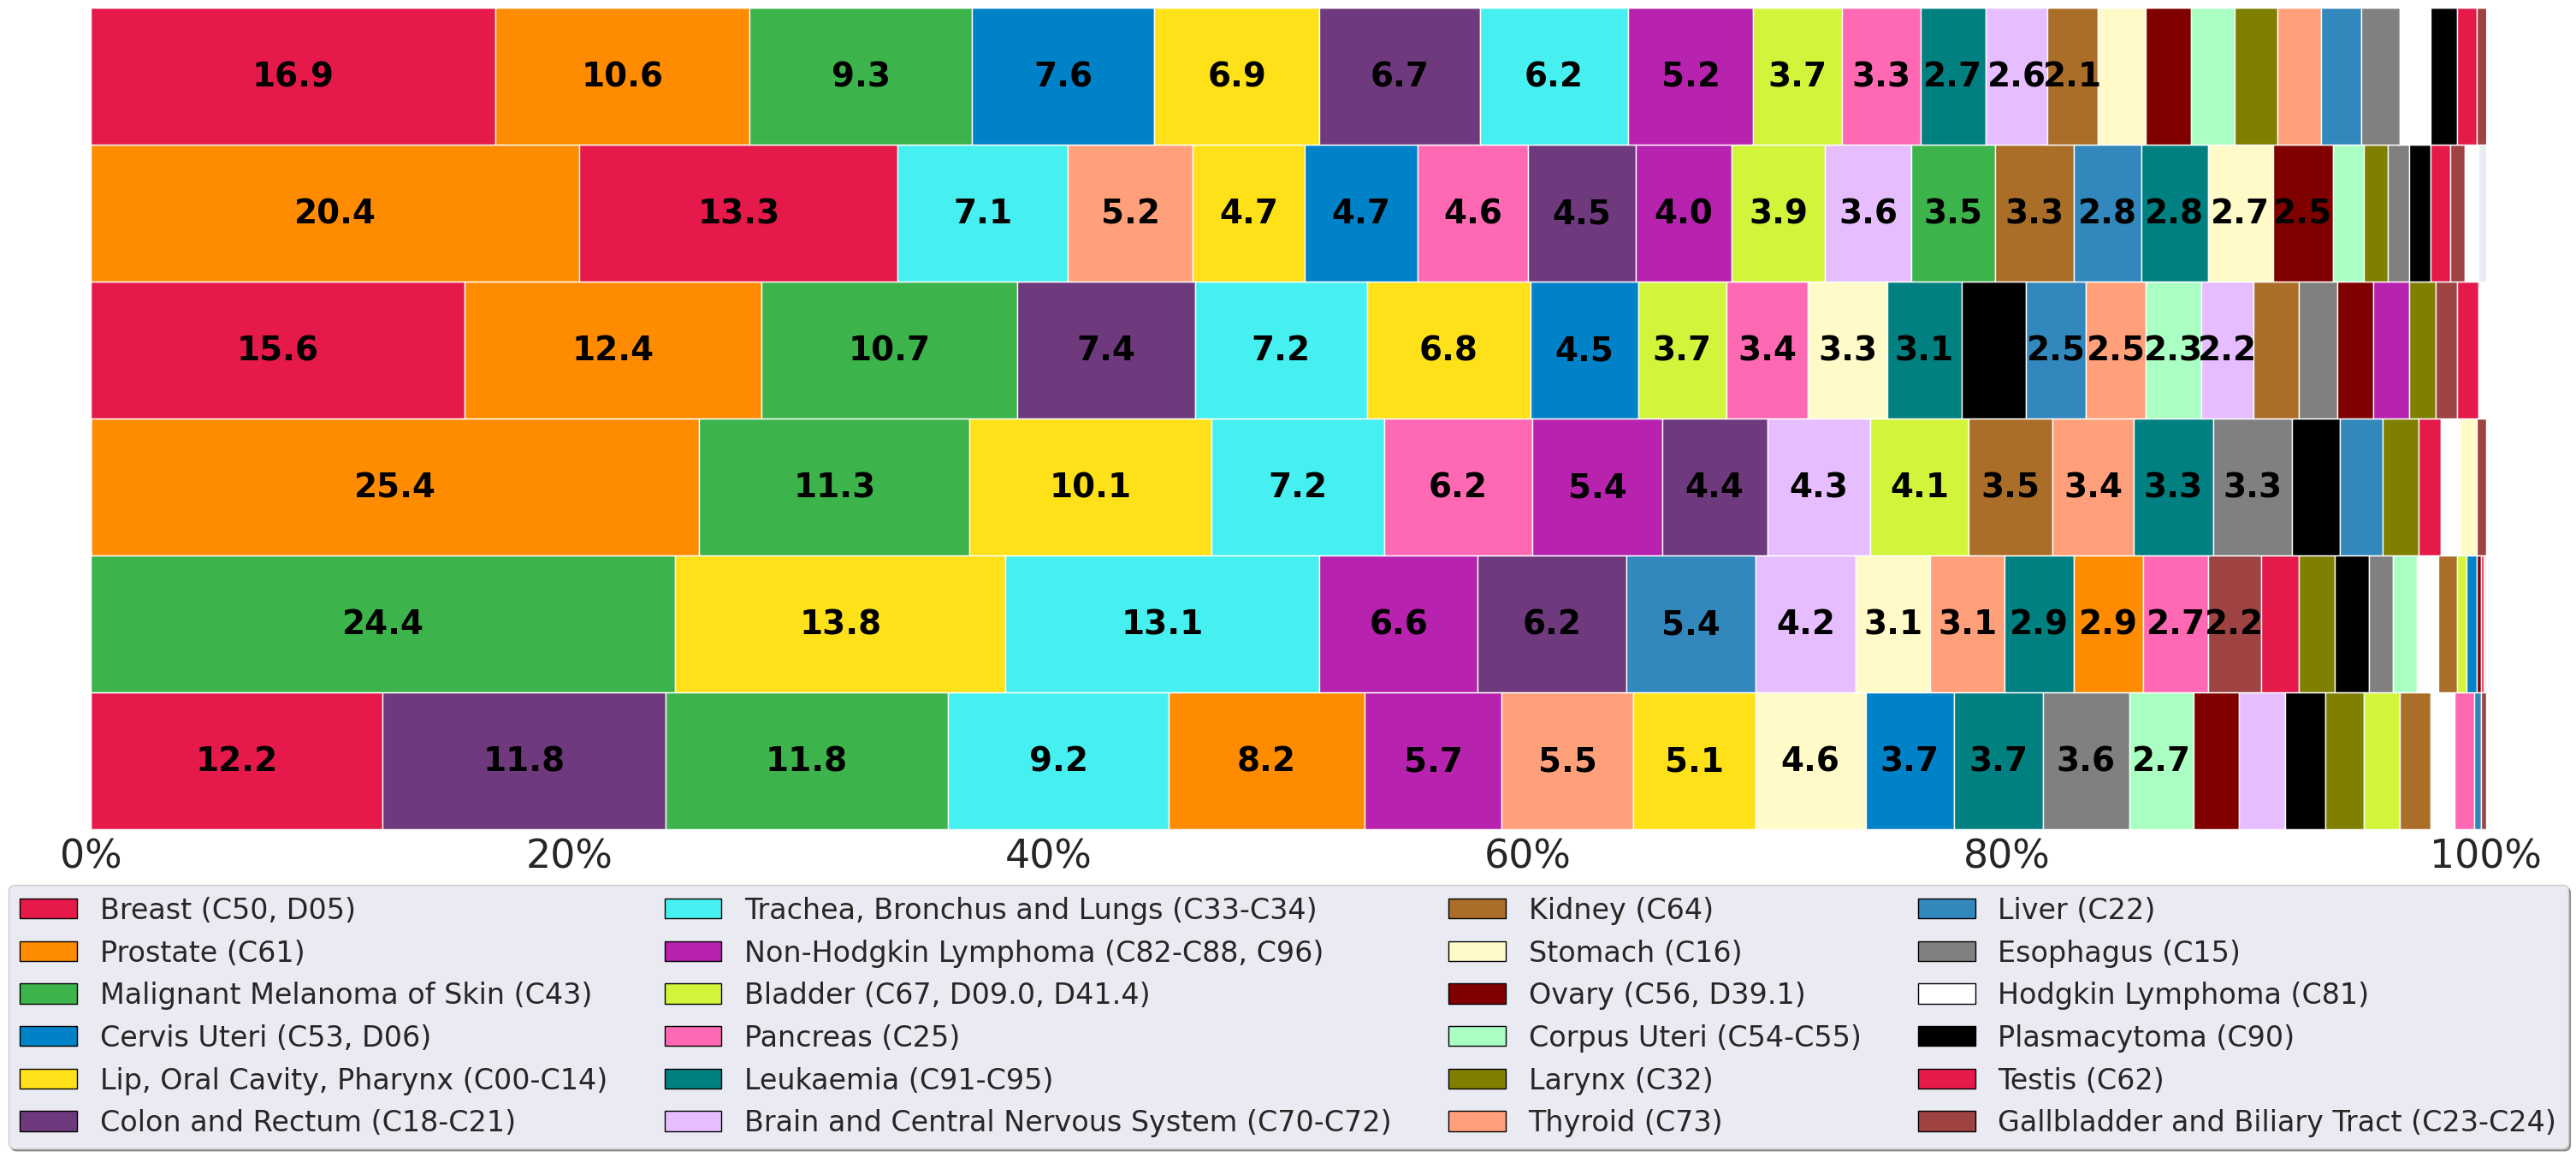

In [38]:
plot_all_sites(pivoted_dfs)